[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-1/router.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239412-lesson-5-router)


# 路由器（Router）

## 回顾

我们构建了一个使用 `messages` 作为状态，并在节点中绑定了工具的聊天模型图。

我们看到该图可以：

* 返回一个工具调用
* 返回一段自然语言回复

## 目标

我们可以将其视为一个路由器：聊天模型会根据用户输入，在直接回复或工具调用之间进行路由。

这是一个简单的智能体示例，其中 LLM 通过调用工具或直接回复来引导控制流。

![Screenshot 2024-08-21 at 9.24.09 AM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbac6543c3d4df239a4ed1_router1.png)

让我们扩展图，使其能够处理这两种输出！

为此我们将用到两个想法：

(1) 添加一个调用工具的节点。

(2) 添加一个条件边：根据聊天模型的输出，若产生了工具调用则路由到调用工具的节点；否则如果没有工具调用就直接结束。


In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph langgraph-prebuilt

In [2]:
import os, getpass


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


# _set_env("OPENAI_API_KEY")
_set_env("DASHSCOPE_API_KEY")

In [3]:
# from langchain_openai import ChatOpenAI
from langchain_community.chat_models import ChatTongyi


def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b


# llm = ChatOpenAI(model="gpt-4o")
llm = ChatTongyi(model="qwen-plus")
llm_with_tools = llm.bind_tools([multiply])

我们使用[内置的 `ToolNode`](https://langchain-ai.github.io/langgraph/reference/prebuilt/?h=tools+condition#toolnode)，只需传入工具列表进行初始化。

我们将[内置的 `tools_condition`](https://langchain-ai.github.io/langgraph/reference/prebuilt/?h=tools+condition#tools_condition) 用作条件边。


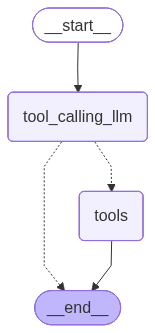

In [ ]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition


# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
# tool_calling_llm 节点给出调用工具的名称和参数
# tools 节点调用工具
builder.add_node("tools", ToolNode([multiply]))
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [5]:
from langchain_core.messages import HumanMessage

messages = [HumanMessage(content="Hello, what is 2 multiplied by 2?")]
messages = graph.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Hello, what is 2 multiplied by 2?
================================== Ai Message ==================================
Tool Calls:
  multiply (call_c45ecdfaf6c94de4a0741b)
 Call ID: call_c45ecdfaf6c94de4a0741b
  Args:
    a: 2
    b: 2
================================= Tool Message =================================
Name: multiply

4


现在我们可以看到图实际运行了工具！

它返回了一个 `ToolMessage`。

## LangGraph Studio

**⚠️ 说明**

自这些视频录制以来，我们已更新了 Studio，使其可以在本地运行并在浏览器中打开。现在推荐以这种方式运行 Studio（而不是视频中展示的桌面应用）。有关本地开发服务器的文档见[这里](https://langchain-ai.github.io/langgraph/concepts/langgraph_studio/#local-development-server)，如何运行本地 Studio 见[这里](https://langchain-ai.github.io/langgraph/how-tos/local-studio/#run-the-development-server)。要启动本地开发服务器，请在本模块的 `/studio` 目录下运行：

```
langgraph dev
```

你应该能看到如下输出：
```
- 🚀 API: http://127.0.0.1:2024
- 🎨 Studio UI: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024
- 📚 API Docs: http://127.0.0.1:2024/docs
```

在浏览器中打开 Studio UI：`https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024`。
在 Studio 中加载 `router`，它使用的是 `module-1/studio/langgraph.json` 中设置的 `module-1/studio/router.py`。


In [ ]:
if "google.colab" in str(get_ipython()):
    raise Exception(
        "Unfortunately LangGraph Studio is currently not supported on Google Colab"
    )